In [1]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

import bpy
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle
import glob

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var
from object_pose_utils.utils.display import *

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [92]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''
    ax.set_aspect('equal')

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


## Dataset Information

In [2]:
dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'

non_sym_objs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18,]
sym_objs = [13, 16, 19, 20, 21]
textureless_objects = set([10, 11, 13, 14, 16, 19, 20, 21])
textured_objects = set(range(1,22)) - set([10, 11, 13, 14, 16, 19, 20, 21])


with open('{0}/image_sets/classes.txt'.format(dataset_root)) as f:                                    
    classes = f.read().split()
classes.insert(0, '__background__')

In [3]:
from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from generic_pose.losses.bingham_loss import isoLikelihood, duelLikelihood

tetra_interp = TetraInterpolation(2)

def estimateLikelihood(lik_distribution, quat, k=4):
    if(type(lik_distribution) in [BinghamInterpolation,isoLikelihood, duelLikelihood]):
        lik = lik_distribution(quat.unsqueeze(0).cuda()).item()
    else:
        if(type(lik_distribution) is torch.Tensor):
            lik_distribution = to_np(lik_distribution.flatten())
        tetra_interp.setValues(lik_distribution)
        lik = tetra_interp.smooth(to_np(quat), k=k).item()
    return lik

In [4]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.inplane_rotation_augmentation import InplaneRotator

from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.TRANSLATION, 
                 otypes.IMAGE,
                 otypes.DEPTH_IMAGE,
                ]

dataset = YCBDataset(dataset_root, mode=mode,
                     object_list = list(range(1,22)),
                     output_data = output_format,
                     resample_on_error = False,
                     add_syn_background = False,
                     add_syn_noise = False,
                     use_posecnn_data = True,
                     #preprocessors = [InplaneRotator()],
                     #postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)

model_clouds = {}
for object_id in object_list:
    cloud_filename = '{}/models/{}/points.xyz'.format(dataset_root, dataset.classes[object_id])
    model_clouds[object_id] = np.loadtxt(cloud_filename)

In [5]:
from quat_math import quaternion_matrix, euler_matrix
def getYCBTransform(q, t=[0,0,.5]):
    trans_mat = quaternion_matrix(q)
    ycb_mat = euler_matrix(-np.pi/2,0,0)
    trans_mat = trans_mat.dot(ycb_mat)
    trans_mat[:3,3] = t
    return trans_mat

In [6]:
from model_renderer.pose_renderer import BpyRenderer
from generic_pose.datasets.ycb_dataset import ycbRenderTransform

fx = 1066.778
fy = 1067.487
px = 312.9869
py = 241.3109

meta_data = {}
meta_data['camera_fx'] = fx
meta_data['camera_fy'] = fy
meta_data['camera_cx'] = px
meta_data['camera_cy'] = py

renderer = BpyRenderer(transform_func = ycbRenderTransform)
renderer.setCameraMatrix(fx, fy, px, py, 640, 480)
renderer.setDepth()

In [7]:
def poseLikelihoods(lik_distributions, poses):
    pose_lik = {}
    for obj in range(1,22):
        pose_lik[obj] = {}
        for j in poses[obj].keys():
            pose_lik[obj][j] = estimateLikelihood(lik_distributions[obj][j], torch.from_numpy(poses[obj][j][0]))
    return pose_lik

In [8]:
pc_data = np.load('iros_results/posecnn.npz', allow_pickle=True)
pc_gt = pc_data['pose_gt'].item()
pc_est = pc_data['pose_est'].item()
pc_add = pc_data['add_error'].item()
pc_adi = pc_data['add_sym_error'].item()
pc_ang = pc_data['sym_angular_error'].item()

data = np.load('ral_results/indiv_new/pcnn_hist_comp_fc6.npz', allow_pickle=True)
print(data['likelihood'].item()['hist_comp_fc6'][1][0])
fn = 'ral_results/pcnn_single_img_hist_comp_fc6_results.npz'
data = np.load(fn, allow_pickle=True)
print(data['likelihood'].item()['hist_comp_fc6'][1][0])
pc_hist_distributions = data['lik_distribution'].item()['hist_comp_fc6']

pc_hist_comp_lik_est = poseLikelihoods(pc_hist_distributions, pc_est)
pc_hist_comp_lik_gt = poseLikelihoods(pc_hist_distributions, pc_gt)

15.212597548897463
15.212597548897463


In [9]:
df_data = np.load('iros_results/dense_fusion.npz', allow_pickle=True)
df_gt = df_data['pose_gt'].item()
df_est = df_data['pose_est'].item()
df_add = df_data['add_error'].item()
df_adi = df_data['add_sym_error'].item()
df_ang = df_data['sym_angular_error'].item()

data = np.load('ral_results/indiv_new/df_bing_iso.npz', allow_pickle=True)
print(data['likelihood'].item()['bing_iso'][1][0])
fn = 'ral_results/final_single_img_hist_reg_local_hist_reg_global_hist_comp_local_hist_comp_global_bing_iso_bing_duel_results.npz'
data = np.load(fn, allow_pickle=True)
print(data['likelihood'].item()['bing_iso'][1][0])
fn = 'ral_results/final_single_img_hist_reg_local_hist_reg_global_hist_comp_local_hist_comp_global_bing_iso_bing_duel_dists.npz'
data = np.load(fn, allow_pickle=True)
df_bing_distributions = data['lik_distribution'].item()['bing_iso']

df_bing_iso_lik_est = poseLikelihoods(df_bing_distributions, df_est)
df_bing_iso_lik_gt = poseLikelihoods(df_bing_distributions, df_gt)

97.152587890625
97.152587890625


In [72]:
model_filename = dataset_root + '/models/{}/textured.obj'

obj = 12

renderer.deleteAll()
renderer.loadModel(model_filename.format(classes[obj]), emit = 0.5)

(  0.0001 sec |   0.0001 sec) Importing OBJ '/ssd0/datasets/ycb/YCB_Video_Dataset/models/021_bleach_cleanser/textured.obj'...
  (  0.0012 sec |   0.0009 sec) Parsing OBJ file...
    (  7.9977 sec |   7.9965 sec) Done, loading materials and images...
    (  7.9997 sec |   7.9984 sec) Done, building geometries (verts:262146 faces:524288 materials: 1 smoothgroups:1) ...
    ( 19.5252 sec |  19.5239 sec) Done.
  ( 19.5254 sec |  19.5252 sec) Finished importing: '/ssd0/datasets/ycb/YCB_Video_Dataset/models/021_bleach_cleanser/textured.obj'
Progress: 100.00%



UUID('7a41f52d-478c-43d5-81f4-c276f51e0987')

In [ ]:
tetra_interp_obs = TetraInterpolation(2)
grid_vertices = tetra_interp_tracking.kd_grid.grid.vertices


In [99]:
%matplotlib notebook

pylab.rcParams['figure.figsize'] = 20, 12

from tqdm import tqdm_notebook as tqdm
import time

fig = plt.figure()
ax_est = fig.add_subplot(131, projection='3d')
ax_predict = fig.add_subplot(132, projection='3d')
ax_update = fig.add_subplot(133, projection='3d')

video_id = None

track_likelihoods = []
tetra_interp.setValues(np.ones(len(grid_vertices)))

eps_m = 1e-6
eps_s = 1e-6



for idx in tqdm(range(len(dataset))):
    path = dataset.getPath(idx).split('/')
    
    if(video_id is None):
        video_id = path[0]
    
    if(video_id != path[0]):
        break

        
    obj, q_gt, t_gt, img, depth = dataset[idx]
    obj = obj.item()
    q_gt = to_np(q_gt)
    t_gt = to_np(t_gt)
    img = torch2Img(img).astype(np.uint8)
    q_est, t_est = pc_est[obj][idx]
    
    # Predict
    tetra_interp.setValues(lik_update)
    lik_predict = tetra_interp.smooth(grid_vertices, k=20) 
    
    lik_est = pc_hist_distributions[obj][idx]
    tetra_interp.setValues(lik_est)
    lik_est = tetra_interp.smooth(grid_vertices, k=20) 

    # Update
    lik_update = (lik_predict + eps_m)*(lik_est + eps_s)
    track_likelihoods.append(lik_update.copy())
    tetra_interp.setValues(lik_update)

    # Display Estimate
    ax_est.clear()
    scatterSO3(grid_vertices, lik_est, 
           alims = [0.1,1.], ax = ax_est)

    pts = quats2Point([q_est])
    ax_est.scatter(pts[:,0], pts[:,1], pts[:,2], s=100, 
                      marker='o', facecolors='none', edgecolors='k')
    pts = quats2Point([q_gt])
    ax_est.scatter(pts[:,0], pts[:,1], pts[:,2], s=100, 
                      marker='x', color='k')
    set_axes_equal(ax_est)

    # Display Predict
    ax_predict.clear()
    scatterSO3(grid_vertices, lik_predict, 
               [q_gt, q_est], alims = [0.1,1.], ax = ax_predict)
    set_axes_equal(ax_predict)

    # Display Update
    ax_update.clear()
    scatterSO3(grid_vertices, lik_update, 
               alims = [0.1,1.], ax = ax_update)
    pts = quats2Point([q_est])
    ax_update.scatter(pts[:,0], pts[:,1], pts[:,2], s=100, 
                      marker='o', facecolors='none', edgecolors='k')
    pts = quats2Point([q_gt])
    ax_update.scatter(pts[:,0], pts[:,1], pts[:,2], s=100, 
                      marker='x', color='k')
    set_axes_equal(ax_update)
    
    fig.canvas.draw()
    time.sleep(0.1)
    
    #break
    

<IPython.core.display.Javascript object>

NameError: name 'lik_update' is not defined

In [85]:
ax

In [62]:
estimateLikelihood(track_likelihoods[-1], 
                   torch.from_numpy(q_est))


8.008604021835181e-08

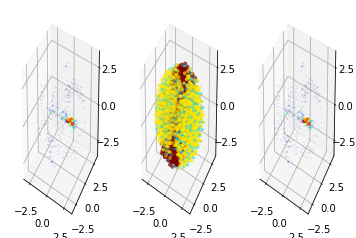

In [10]:
print(idx)

print(dataset.getPath(idx))
print('add', pc_add[obj][idx])
print('lik_gt', pc_hist_comp_lik_gt[obj][idx])
print('lik_est', pc_hist_comp_lik_est[obj][idx])
print('q_gt ', q_gt)
print('q_est', q_est)

print('t_gt', t_gt)
print('t_est', t_est)